# Lab 12. Model regresyjny

## 1. Budowa modelu regresyjnego do predykcji ceny mieszkań

### 1.1 Wstępna analiza i przygotowanie danych

In [2]:
# import niezbędnych bibliotek
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Dane, na których zaprezentowany zostanie przykład to dane z serwisu www.kaggle.com.

**Dataset:** https://www.kaggle.com/datasets/amrahhasanov23/otodom-pl-flat-prices-in-poland

In [ ]:
!pip install kagglehub

In [43]:
import kagglehub

# plik pobiera się niestety bez podania ścieżki docelowej, więc zapewne będzie to jakiś folder tymczasowy
path = kagglehub.dataset_download("amrahhasanov23/otodom-pl-flat-prices-in-poland")

print("Ścieżka do pliku:", path)

100%|████████████████████████████████████████████████████████████| 179k/179k [00:00<00:00, 460kB/s]

Extracting files...
Ścieżka do pliku: C:\Users\Krzysztof\.cache\kagglehub\datasets\amrahhasanov23\otodom-pl-flat-prices-in-poland\versions\1


In [44]:
# deklarujemy stałą, która będzie niezmienna (to znowu taka umowa/konwencja), która wskazuje na ścieżkę do głównego
# katalogu z danymi dla tego notebooka
DATAPATH = './data'

import os

os.makedirs(DATAPATH, exist_ok=True)

In [45]:
# przeniesiemy plik do folderu z danymi, który utworzyliśmy wcześniej
import shutil

# zakładamy, że jest tam tylko jeden plik, więc listujemy folder i pobieramy pierwszą nazwę pliku
filename = os.listdir(path)[0]

shutil.move(os.path.join(path, filename), os.path.join(DATAPATH, filename))

'./data\\Otodom_Flat_Listings.csv'

In [46]:
# sprawdzamy czy plik faktycznie się przeniósł
os.listdir(DATAPATH)

['Otodom_Flat_Listings.csv']

Alternatywnie można oczywiście pobrać zbiór bezpośrednioze strony internetowej, rozpakować go i umieścić w folderze docelowym.

Zobaczmy teraz jak wyglądają nasze dane. Zachęcam również do spojrzenia na **datacard** tego zbioru na stronie serwisu Kaggle.

In [47]:
otodf = pd.read_csv(os.path.join(DATAPATH, filename))
otodf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2807 entries, 0 to 2806
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   2807 non-null   object 
 1   Price                   2664 non-null   float64
 2   Location                2806 non-null   object 
 3   Surface                 2807 non-null   float64
 4   Number_of_Rooms         2807 non-null   object 
 5   Floor                   2743 non-null   object 
 6   Finishing_Condition     2229 non-null   object 
 7   Heating                 2060 non-null   object 
 8   Parking_Space           1478 non-null   object 
 9   Balcony_Garden_Terrace  2102 non-null   object 
 10  Link                    2807 non-null   object 
 11  Voivodeship             2806 non-null   object 
 12  City                    2806 non-null   object 
dtypes: float64(2), object(11)
memory usage: 285.2+ KB


In [49]:
otodf.head()

,Title,Price,Location,Surface,Number_of_Rooms,Floor,Finishing_Condition,Heating,Parking_Space,Balcony_Garden_Terrace,Link,Voivodeship,City
0,2 pokoje 47m2 po remoncie + garderoba + balkon,415000.0,"ul. Marysińska, Stare Bałuty, Bałuty, Łódź, łó...",47.0,2,NaN,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-pokoje-47m2-...,Łódzkie,Łódź
1,Właściciel- Ludwiki DD - WIDOK NA ZIELEŃ - 2x gar,2499000.0,"ul. Ludwiki, Czyste, Wola, Warszawa, mazowieckie",105.0,4,2/8,do wykończenia,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/wlasciciel-lud...,Mazowieckie,Warszawa
2,"Sprzedam mieszkanie 60m2, 2 balkony, garderoba",649000.0,"ul. Londyńska, Gorzów Wielkopolski, lubuskie",60.0,3,4/4,do zamieszkania,miejskie,NaN,"balkon, taras",https://www.otodom.pl/pl/oferta/sprzedam-miesz...,Lubuskie,Gorzów Wielkopolski
3,"Wyjątkowy, duży apartament z antresolą",2108000.0,"Mrzeżyno, Trzebiatów, gryficki, zachodniopomor...",78.3,3,4/4,do wykończenia,NaN,garaż/miejsce parkingowe,NaN,https://www.otodom.pl/pl/oferta/wyjatkowy-duzy...,Zachodniopomorskie,gryficki
4,"2/3-pok. 49,2 m2 w samym sercu Koszalina - Kuncer",450180.0,"ul. Bartosza Głowackiego, Koszalin, zachodniop...",49.2,2,2/3,do zamieszkania,miejskie,garaż/miejsce parkingowe,balkon,https://www.otodom.pl/pl/oferta/2-3-pok-49-2-m...,Zachodniopomorskie,Koszalin


In [51]:
otodf.isna().sum()

Title                        0
Price                      143
Location                     1
Surface                      0
Number_of_Rooms              0
Floor                       64
Finishing_Condition        578
Heating                    747
Parking_Space             1329
Balcony_Garden_Terrace     705
Link                         0
Voivodeship                  1
City                         1
dtype: int64

Trzeba przyznać, że w zbiorze jest sporo elementów, nad którymi należy popracować zanim będzie można dane "wrzucić" do modelu ML i liczyć na jakieś sensowne wyniki. Sporo jest danych tekstowych, które w takiej formie na pewno nam się nie przydadzą, ale po ich przekształceniu powinniśmy uzyskać lepsze rezultaty - chociaż aktualnie jest to niestety "wróżenie z fusów" ;-).

W zbiorze sporo jest też wartości brakujących, z których część jest kłopotliwa (cena), a z częścią może będziemy mogli sobie jakoś sensownie poradzić (np. miejsce parkingowe).

**Zaczniemy od czegoś prostego.**

Na początek weźmiemy pod uwagę tylko 2 cechy - cenę oraz powierzchnię mieszkania, ale tylko te, które nie mają wartości Nan.

In [57]:
otodf_1 = otodf[['Surface', 'Price']]
otodf_1 = otodf_1.dropna()
otodf_1

,Surface,Price
0,47.00,415000.0
1,105.00,2499000.0
2,60.00,649000.0
3,78.30,2108000.0
4,49.20,450180.0
...,...,...
2802,34.00,525000.0
2803,61.18,829000.0
2804,50.00,830000.0
2805,66.47,699000.0


Sprawdźmy teraz jak wygląda korelacja tych dwóch cech, możemy się domyślać, że jest raczej wysoka i dodatnia (jeżeli wartość jednej z cech rośnie, to drugiej również).

<Axes: >

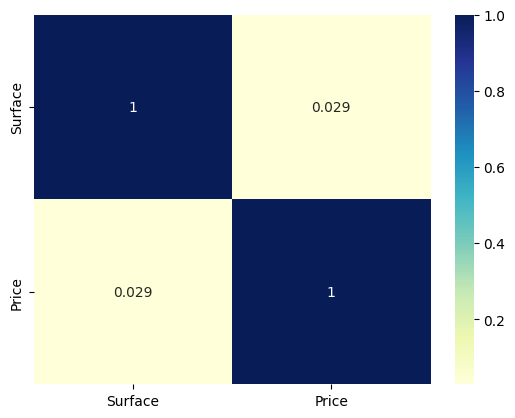

In [58]:
corr = otodf_1.corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
# plt.show()

**Wnioski**

Nasze założenie było jednak błędne, korelacja jest co prawda dodatnia, ale bardzo niska. To na pewno będzie więc za mało dla naszego modelu regresji, aby na podstawie samej tylko powierzchni generować predykcję ceny.

Zobaczmy jeszcze na wykres typu scatter jak to wygląda.

<Axes: >

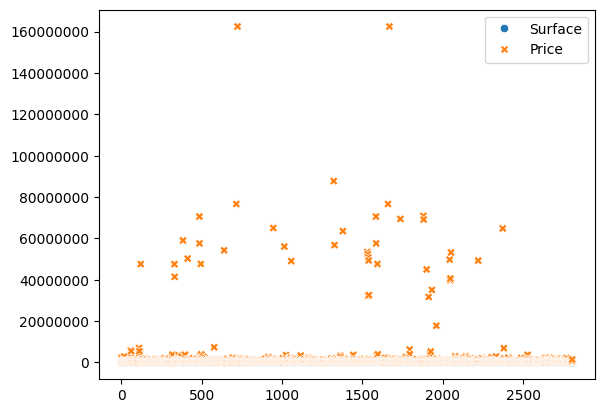

In [69]:
f, ax = plt.subplots()
ax.ticklabel_format(style='plain', axis='both')
sns.scatterplot(otodf_1, ax=ax)

Widać wyraźnie, że mamy tu do czynienia z wartościami odstającymi, które będą zaburzały model.

Widać to również bardzo wyraźnie na wykresie typu boxplot poniżej, gdzie box ze średnią, medianą oraz percentylami 25 i 75 nie jest właściwie widoczny.

<Axes: ylabel='Price'>

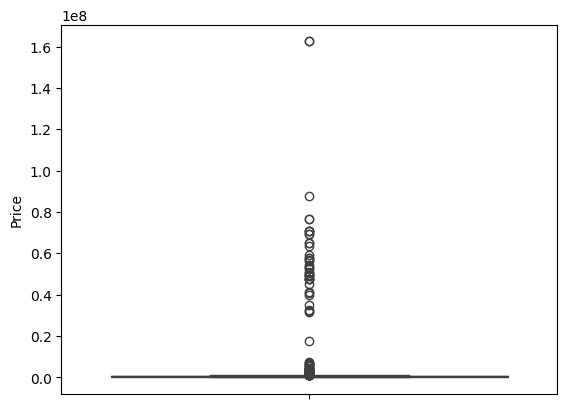

In [74]:
sns.boxplot(otodf_1['Price'])

Wyświetlone podsumowanie głównym statystyk opisowych daje nam bardziej wymierny obraz sytuacji dla podzbioru.

In [65]:
pd.options.display.float_format = '{:.3f}'.format
otodf_1.describe()

,Surface,Price
count,2664.000,2664.000
mean,61.561,1568792.503
std,84.643,7945282.597
min,1.000,44444.000
25%,43.000,395000.000
50%,54.400,573000.000
75%,69.000,780000.000
max,3800.000,162499380.000


Jest wiele metod radzenia sobie z danymi odstającymi (ang. outliers), ale tnie jest to istotą tego labu. Dla przykładu wykorzystane zostaną tutaj przykłady z odcięciem części obserwacji odstających.

Wartości odstające wyliczamy różnymi miarami rozrzutu danych, często wykorzystując rozstęp ćwiartkowy (ang. interquantile range, w skrócie IQR).

Poniżej podstawowe informacje o tym jak jest wyliczany, a następnie policzymy go dla naszego podzbioru.

![boxplot](boxplot.png)

_(źródło: https://www.geeksforgeeks.org/interquartile-range-and-quartile-deviation-using-numpy-and-scipy/)_

**Rozstęp ćwiartkowy to różnica Q3 oraz Q1:**

_IQR= Q3 − Q1_

Jednym ze sposobów na wskazanie wartości odstających jest wykorzystanie wyliczonego **IQR** tak, że wszystkie wartości, które znajdują się poniżej **Q1 – 1.5*IQR** lub powyżej **Q3 + 1.5*IQR** mogą być traktowane jako wartości odstające.

Policzmy zatem te wartości dla naszego podzbioru.

In [124]:
# policzymy wartości kwantyli dla kolumny Price
q1 = np.percentile(otodf_1['Price'], 25)
q3 = np.percentile(otodf_1['Price'], 75)
iqr = q3 - q1

# teraz progi dla wartości odstających
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(f'Q1: {q1}', f'Q3: {q3}', f'IQR: {iqr}', f'Lower outlier threshold: {lower}', f'Upper outlier threshold: {upper}', sep='\n')

Q1: 395000.0
Q3: 780000.0
IQR: 385000.0
Lower outlier threshold: -182500.0
Upper outlier threshold: 1357500.0


Te wartości spróbujemy wykorzystać później do porównania jakości różnych modeli regresji, które stworzymy dla tego zbioru.

### 1.2 Szacowanie parametrów regresji

Wykorzystując biblioteke `scikit-learn` stworzymy model regresji dla naszego podzbioru bez jego modyfikacji, jako model bazowy.

In [122]:
# 1. podział danych na 4 podzbiory
X = otodf_1['Surface'].values.reshape(-1, 1)
y = otodf_1['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

<Axes: >

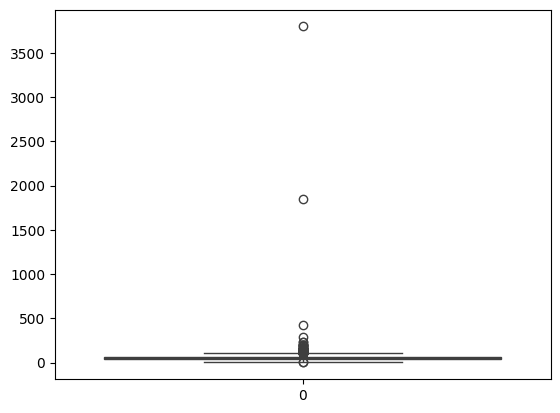

In [123]:
sns.boxplot(X_train)

In [113]:
# 2. tworzenie modelu regresji

lin_reg = LinearRegression()

# Dopasowuje model regresji liniowej
lin_reg.fit(X_train, y_train)

# Przewiduje wartości na podstawie zestawu testowego
predictions = lin_reg.predict(X_test)

# Wyświetla wartości punktu przecięcia z osią x i współczynników modelu
print("Punkt przecięcia:", lin_reg.intercept_)
print("Współczynniki:", lin_reg.coef_)

Punkt przecięcia: 1393959.888424575
Współczynniki: [2375.36188693]


In [114]:
# wyliczmy również miary modelu tak jak na wykładzie
print('Średni błąd bezwzględny (MAE):', mean_absolute_error(y_test, predictions))
print("Błąd średniokwadratowy (MSE):", mean_squared_error(y_test, predictions))
print("Pierw. błędu średniokwadratowego (RMSE):", np.sqrt(mean_squared_error(y_test, predictions)))
print("Współczynnik determinacji R-kwadrat:", r2_score(y_test, predictions))

Średni błąd bezwzględny (MAE): 1875141.1343519343
Błąd średniokwadratowy (MSE): 81450569367726.75
Pierw. błędu średniokwadratowego (RMSE): 9024996.917879073
Współczynnik determinacji R-kwadrat: 0.0004911898590828079


Można już na tej podstawie wywnioskować, że model jest słaby, gdyż wartość funkcji błędów jest wysoka, a miara R2 jest bardzo niska.
Ten wynik był jednak do przewidzenia biorąc pod uwagę wcześniejszą analizę danych tylko dla tej jednej cechy (`Surface`) względem ceny (`Price`).

Tutaj również widać, że model nie posiada wysokiej zależności liniowej, więc regresj aliniowa może nie być dobrym podejściem do modelowania tego zbioru.

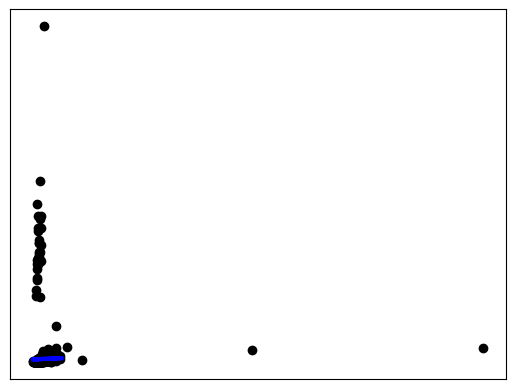

In [115]:
# wyświetlamy wyliczoną linię regresji
plt.scatter(X_train, y_train, color="black")
plt.plot(X_test, predictions, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [125]:
# teraz sprónujemy wykorzystać wyliczone miary wartości odstających, aby zobaczyć, czy przyniesie to lepszy wynik
# podział danych pozostaje taki jak jest, zmodyfikujemy tylko dwa podzbiory X_train, y_train, gdyż z danych
# treningowych chcemy pozbyć się wartości odstających

# ile jest tych wartości odstających?
sum((y_train > upper) | (y_train < lower))

149

In [126]:
outiers_map = (y_train > upper) | (y_train < lower)
# odrzucamy pozycje gdzie wykryto wartości odstające
# znak ~ oznacza negację
X_train = X_train[~outiers_map]
y_train = y_train[~outiers_map]

<Axes: >

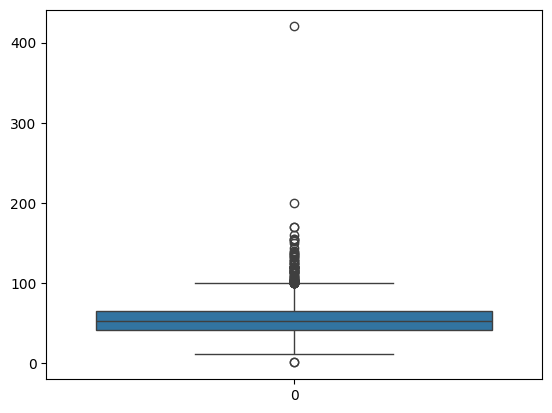

In [127]:
# po usunięciu wartości odstających
# lepiej, ale wciąż nie jest zbyt dobrze
sns.boxplot(X_train)

In [128]:
# trenujemy model raz jeszcze na danych bez wartości odstających
lin_reg = LinearRegression()

# Dopasowuje model regresji liniowej
lin_reg.fit(X_train, y_train)

# Przewiduje wartości na podstawie zestawu testowego
predictions = lin_reg.predict(X_test)

# Wyświetla wartości punktu przecięcia z osią x i współczynników modelu
print("Punkt przecięcia:", lin_reg.intercept_)
print("Współczynniki:", lin_reg.coef_)

Punkt przecięcia: 272694.90883891965
Współczynniki: [5274.71542661]


In [129]:
# wyliczmy również miary modelu tak jak na wykładzie
print('Średni błąd bezwzględny (MAE):', mean_absolute_error(y_test, predictions))
print("Błąd średniokwadratowy (MSE):", mean_squared_error(y_test, predictions))
print("Pierw. błędu średniokwadratowego (RMSE):", np.sqrt(mean_squared_error(y_test, predictions)))
print("Współczynnik determinacji R-kwadrat:", r2_score(y_test, predictions))

Średni błąd bezwzględny (MAE): 1220567.1257313679
Błąd średniokwadratowy (MSE): 82510463499397.38
Pierw. błędu średniokwadratowego (RMSE): 9083527.040714823
Współczynnik determinacji R-kwadrat: -0.012515146752742234


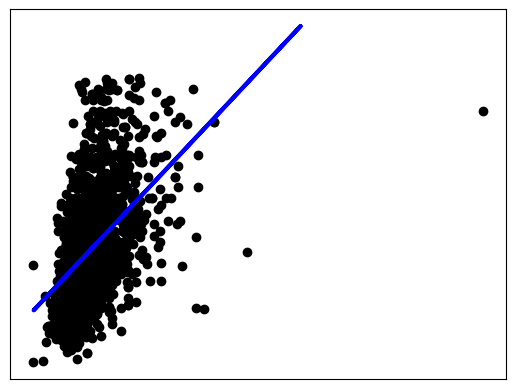

In [130]:
# wyświetlamy wyliczoną linię regresji
plt.scatter(X_train, y_train, color="black")
plt.plot(X_test, predictions, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

**Wnioski**

Model wydaje się lepiej dopasowany do danych, ale na pewno widać mniejszy wpływ danych odstających.

Daleko jendak jest jeszcze do końca naszej pracy.

## Zadania

**Zadanie 1**

Bazując na przykładzie z wykładu stwórz model regresji wielomianowej dla dwóch stworzonych tutaj modeli regresji liniowej. Porównaj wyniki.

**Zadanie 2**

Dodaj do zbioru danych cechę `Number of rooms` i sprawdź jak to wpływa na jakość modelu.

**Zadanie 3**

Zakoduj cechę `Voivoideship` metodą one-hot, wykorzystaj w zbiorze danych i ponownie sprawdź jaki to ma wpływ na model.